# Tate's init

Let's try some of the rasterio things that Micah Presented to get LiDAR Snow Depth at a few select pits.

In [1]:
# Import the function to get connect to the db
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from snowexsql.data import ImageData

# What will this return?
result = session.query(ImageData.raster).limit(1).all()

print(type(result[0][0]))

<class 'geoalchemy2.elements.RasterElement'>


In [18]:
# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 

# Import this to convert to a rasterio object for easy plotting
from snowexsql.conversions import raster_to_rasterio 

# Import a convenient function to plot with 
from rasterio.plot import show

1


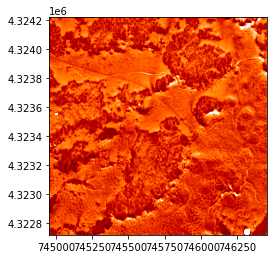

<AxesSubplot:>

In [5]:
# import our pits metadata table class
from snowexsql.data import SiteData
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
from geoalchemy2.shape import to_shape

session.rollback()

# 1. Lets choose a site we want to grab a raster tile
site_id = '5S31'

# 2. Get the location of the pit, POSTGIS functions like to work in the text format of things so convert the point geom to text which is also in binary in the db   
point = session.query(SiteData.geom).filter(SiteData.site_id == site_id).distinct().all()[0][0]

# 3. Merge all the tiles together, note gfunc vs func. This is because ST_Union exists in two places in postgis for geom and rasters!
base = gfunc.ST_Union(ImageData.raster, _type=Raster)

# 4. Get the merged result as a geotiff! 
base = func.ST_AsTiff(base)

# 5. Filter by uavsar interferogram data
#qry = session.query(base).filter(ImageData.type == 'insar interferogram real')
qry = session.query(base).filter(ImageData.type == 'depth')


# 6. Filter by a polarization in the description 
#qry = qry.filter(ImageData.description.contains('Polarization = HH'))

# 7. Isolate tiles touching the pit location
qry = qry.filter(func.ST_Intersects(ImageData.raster, point))

print(qry.count())

# 8. Execute, convert and plot! 
result = qry.all()
datasets = raster_to_rasterio(session, result)
numerical = datasets[0].read(1)
#show(datasets[0], vmin=-0.02, vmax=0.02, cmap='Purples')
show(datasets[0], vmin=0, vmax=1.5, cmap='gist_heat')


In [6]:
tmp = session.query(ImageData.type).distinct().all()
print(tmp)
tmp = session.query(ImageData.instrument).distinct().all()
print(tmp)

[('swe',), ('DEM',), ('insar amplitude',), ('insar correlation',), ('depth',), ('insar interferogram real',), ('insar interferogram imaginary',)]
[('UAVSAR, L-band InSAR',), ('lidar',)]


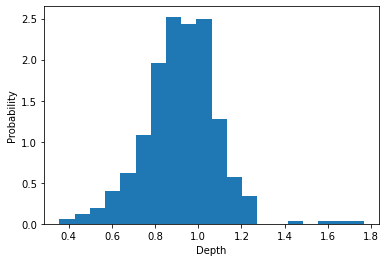

In [7]:
plt.hist(numerical[0], density=True, bins=20)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Depth');

In [8]:
datasets[0].bounds
#tmp = datasets[0].xy(datasets[0].height // 2, datasets[0].width // 2)
#tmp?

BoundingBox(left=744954.0000015632, bottom=4322717.999887453, right=746454.0000015668, top=4324217.999887457)

In [9]:
coords = []
for i in range(0,datasets[0].width):
    for j in range(0,datasets[0].height):
        coords.append(datasets[0].xy(j, i))


In [28]:
len(coords)==datasets[0].width*datasets[0].height
coords[1000][0]*coords[1001][0]
point
shply_geom = to_shape(point)
shply_geom.y

4322762.0

In [11]:
# Grab our pit geometry (position) object by provided site id from the site details table, Since there is multiple layers and dates we limit the request to 1
qp = session.query(SiteData.geom).filter(SiteData.site_id == site_id).distinct().all()[0][0]
point2 = session.query(qp[0].geom.ST_AsText()).all()
print(point2)


TypeError: 'WKBElement' object is not subscriptable